<a href="https://colab.research.google.com/github/KhoiDOO/Practice/blob/main/ComputerVision/9.%20Weight%20Normalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download, unzip data but falied with X-ray chest data from VIN

In [ ]:
!pip install -U -q kaggle==1.5.8

     |████████████████████████████████| 59 kB 1.6 MB/s 


In [ ]:
!kaggle --version

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kohidocun","key":"061d47a89dadfa1112fd36e20da6226d"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


# Download, Unzip, Preprocess skin cancer data


In [ ]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
import matplotlib.pyplot as plt

In [ ]:
print("API command: {}".format("kaggle datasets download -d fanconic/skin-cancer-malignant-vs-benign"))

API command: kaggle datasets download -d fanconic/skin-cancer-malignant-vs-benign


In [ ]:
!kaggle datasets download -d fanconic/skin-cancer-malignant-vs-benign

 96% 311M/325M [00:09<00:00, 35.8MB/s]
100% 325M/325M [00:09<00:00, 35.3MB/s]


In [ ]:
import zipfile

data_zip_path = "/content/skin-cancer-malignant-vs-benign.zip"
data_root_path = "/content"

with zipfile.ZipFile(data_zip_path, 'r') as zip_ref:
  zip_ref.extractall(data_root_path)

In [ ]:
train_path = "/content/train"
test_path = "/content/test"

train_path = pathlib.Path(train_path)
test_path = pathlib.Path(test_path)

In [ ]:
image_train_count = len(list(train_path.glob('*/*.jpg')))
print(image_train_count)
image_test_count = len(list(test_path.glob('*/*.jpg')))
print(image_test_count)

2637
660


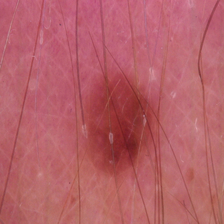

In [ ]:
benign = list(train_path.glob('benign/*'))
PIL.Image.open(benign[0])

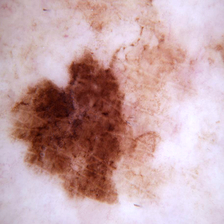

In [ ]:
malignant = list(train_path.glob('malignant/*'))
PIL.Image.open(malignant[0])

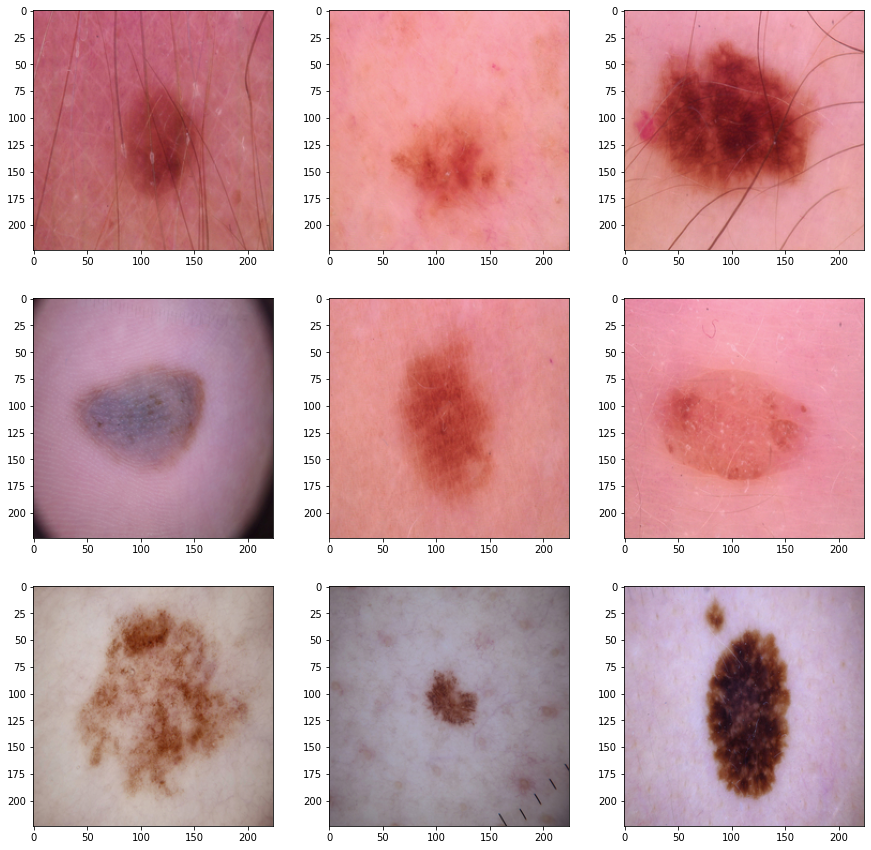

In [ ]:
plt.figure(figsize=(15, 15))
for i in range(9):
  plt.subplot(3, 3, i + 1)
  base = plt.imread(benign[i])
  plt.imshow(base)

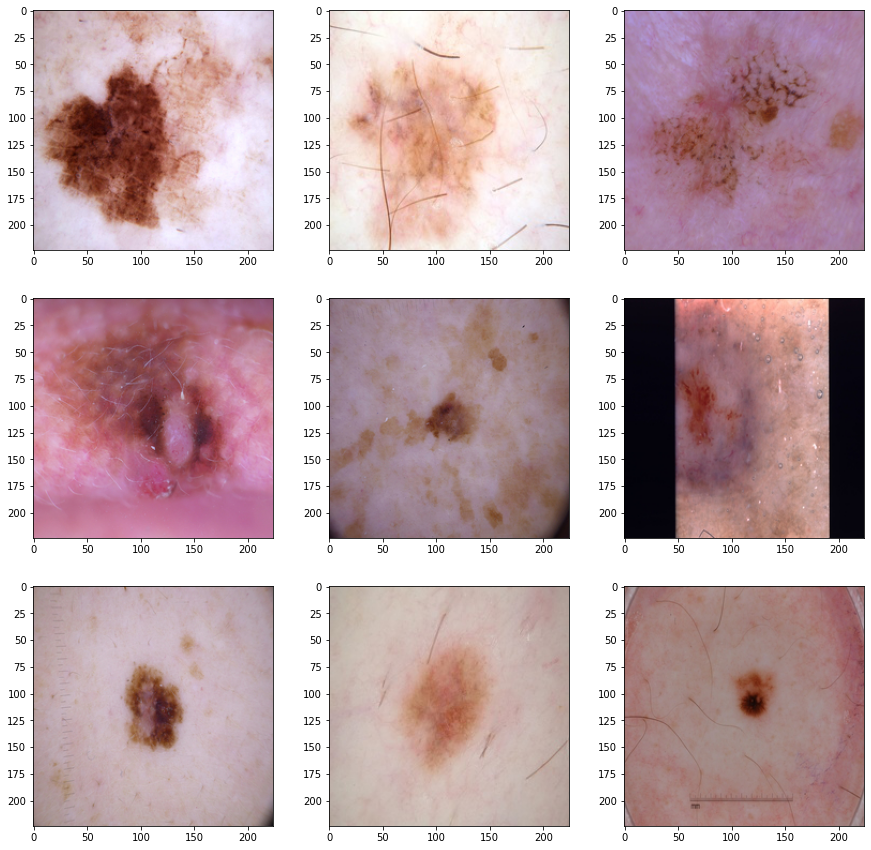

In [ ]:
plt.figure(figsize=(15, 15))
for i in range(9):
  plt.subplot(3, 3, i + 1)
  base = plt.imread(malignant[i])
  plt.imshow(base)

In [ ]:
batch_size = 128
img_height = 250
img_width = 250

In [ ]:
#Creating training, validation and testing set 

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_path,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2637 files belonging to 2 classes.
Using 2110 files for training.
Found 2637 files belonging to 2 classes.
Using 527 files for validation.
Found 660 files belonging to 2 classes.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['benign', 'malignant']


In [ ]:
#Resize and Rescale Model
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
])

In [ ]:
#Data Augmentation Model
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  # tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
  # tf.keras.layers.RandomContrast((0.5,1.5)),
  # tf.keras.layers.RandomHeight((-0.2, 0.3)),
  # tf.keras.layers.RandomWidth((-0.2, 0.3))
])

In [ ]:
# Applied Preprocessing Data
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Use data augmentation only on the training set
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefecting on all datasets
  return ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

In [ ]:
# image, label = next(iter(train_ds))
# x_train = image
# y_train = label

# image, label = next(iter(val_ds))
# x_val = image
# y_val = label

# image, label = next(iter(test_ds))
# x_test = image
# y_test = label

In [ ]:
!pip install -q -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 4.1 MB/s 


In [ ]:
import tensorflow_addons as tfa
from keras.initializers import glorot_normal

In [ ]:
# Main Model
main_model = tf.keras.Sequential([
    tfa.layers.WeightNormalization(tf.keras.layers.Conv2D(32, 5, activation='relu', padding='same', 
                                                          kernel_initializer = glorot_normal(),
                                                          input_shape=(IMG_SIZE,IMG_SIZE,3))),
    tf.keras.layers.MaxPooling2D(2, 2),
    tfa.layers.WeightNormalization(tf.keras.layers.Conv2D(64, 5, activation='relu', padding='same', 
                                                          kernel_initializer = glorot_normal())),
    tf.keras.layers.MaxPooling2D(2, 2),
    tfa.layers.WeightNormalization(tf.keras.layers.Conv2D(128, 5, activation='relu', padding='same', 
                                                          kernel_initializer = glorot_normal())),
    tf.keras.layers.MaxPooling2D(2, 2),
    tfa.layers.WeightNormalization(tf.keras.layers.Conv2D(256, 5, activation='relu', padding='same', 
                                                          kernel_initializer = glorot_normal())),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tfa.layers.WeightNormalization(tf.keras.layers.Dense(2048, activation='relu', 
                                                         kernel_initializer = glorot_normal())),
    tf.keras.layers.Dropout(0.2),
    tfa.layers.WeightNormalization(tf.keras.layers.Dense(1024, activation='relu', 
                                                         kernel_initializer = glorot_normal())),
    tf.keras.layers.Dropout(0.2),
    tfa.layers.WeightNormalization(tf.keras.layers.Dense(512, activation='relu', 
                                                         kernel_initializer = glorot_normal())),
    tf.keras.layers.Dropout(0.2),
    tfa.layers.WeightNormalization(tf.keras.layers.Dense(256, activation='relu', 
                                                         kernel_initializer = glorot_normal())),
    tf.keras.layers.Dropout(0.2),
    tfa.layers.WeightNormalization(tf.keras.layers.Dense(1, activation='sigmoid')),
])

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
epochs = 30

In [ ]:
%load_ext tensorboard
main_model.compile(optimizer='sgd', 
                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                 metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

history = main_model.fit(train_ds,
                         epochs=epochs,
                         validation_data=val_ds,
                         callbacks=[callback],
                         shuffle=True)

Epoch 1/30
33/33 [==============================] - 22s 376ms/step - loss: nan - binary_accuracy: 0.5270 - val_loss: nan - val_binary_accuracy: 0.5541
Epoch 2/30
33/33 [==============================] - 15s 331ms/step - loss: nan - binary_accuracy: 0.5441 - val_loss: nan - val_binary_accuracy: 0.5541
Epoch 3/30
33/33 [==============================] - 15s 330ms/step - loss: nan - binary_accuracy: 0.5441 - val_loss: nan - val_binary_accuracy: 0.5541
